# 统计学习导论第三次作业
作业任务：  
1）决策树模型建模与调参  
2）决策树模型稳健性实验  
3）决策树与Logistic二分类对比

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入
数据来源：阿里天池提供的【Banking Dataset Classification银行数据集分类】  
数据种类：分类数据，分类标签：客户是否已订阅定期存款  
数据网站：https://tianchi.aliyun.com/dataset/92775

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression

## 数据导入
# 阿里天池提供的【Banking Dataset Classification银行数据集分类】
# 分类数据，分类标签：客户是否已订阅定期存款
# https://tianchi.aliyun.com/dataset/92775
data_train = pd.read_csv("/Users/ouyangruizhi/Desktop/python/统计学习导论/决策树/new_train.csv")   # 用的绝对路径
data_test = pd.read_csv("/Users/ouyangruizhi/Desktop/python/统计学习导论/决策树/new_test.csv")

# 展示前五行数据和数据形状
print('前五行数据：')
print(data_train.head())

print('数据形状：')
print(data_train.shape)

前五行数据：
   age           job   marital          education  default housing loan  \
0   49   blue-collar   married           basic.9y  unknown      no   no   
1   37  entrepreneur   married  university.degree       no      no   no   
2   78       retired   married           basic.4y       no      no   no   
3   36        admin.   married  university.degree       no     yes   no   
4   59       retired  divorced  university.degree       no      no   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   nov         wed       227         4    999         0   
1  telephone   nov         wed       202         2    999         1   
2   cellular   jul         mon      1148         1    999         0   
3  telephone   may         mon       120         2    999         0   
4   cellular   jun         tue       368         2    999         0   

      poutcome    y  
0  nonexistent   no  
1      failure   no  
2  nonexistent  yes  
3  nonexistent   no  
4  no

## 二、数据预处理
### 2.1 数据转换
数据中含有大量定性数据，先将数据转换为定量数据

In [2]:
## 数据预处理
# 预处理部分来自：https://tianchi.aliyun.com/notebook/487097
# 缺失值检测
print('原始数据缺失值检测：')
print(data_train.isnull().sum().sum())

# 数据转换
# 定性数据转换为定量数据
# 工作选项
JOB = { 'admin.': 1, 'blue-collar': 2,'entrepreneur': 3,
        'housemaid': 4, 'management': 5, 'retired': 6,
        'self-employed': 7, 'services': 8, 'student': 9,
        'technician': 10, 'unemployed': 11, 'unknown': np.nan}
# 婚姻
MARRY = {'divorced': 1, 'married': 2, 'single': 3,'unknown': np.nan}
# 教育
EDU = {'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3,
       'high.school': 4, 'illiterate': 5, 'professional.course': 6,
       'university.degree': 7, 'unknown': np.nan}
# 违约信用
DEFAULT = {'no': 1,'yes': 2, 'unknown': np.nan}
# 住房贷款
HOUSE_LOAN = {'no': 1, 'yes': 2, 'unknown': np.nan}
# 个人贷款
PER_LOAN = {'no': 1, 'yes': 2, 'unknown': np.nan}
# 接听电话类型
TELE_TYPE = {'cellular': 1,'telephone': 2}
# 最后一次接触月份
LAST_CONTACT_MON = {'nov': 11, 'jul': 7, 'may': 5,
                    'jun': 6, 'aug': 8, 'mar': 3,
                    'oct': 10, 'apr': 4, 'sep': 9,
                    'dec': 12}
# 最后一次接触的星期数
LAST_CONTACT_WEEK = {'mon': 1,'tue': 2, 'wed': 3,
                     'thu': 4, 'fri': 5}
# 前一次接触结果
LAST_CONTACT_POUTCOME = {'failure': 0, 'nonexistent': 1, 'success': 2}
# 预测值
LABELS = {'yes': 1,'no': 0}

# 将 y 名字改为 label, 方便以后操作
data_train.rename(columns={"y": "labels"}, inplace=True)

# 将所有定性数据改为定量数据，找到为 unknow 的元素，缺失值，去掉或用指定值填充
data_train.loc[data_train['job']=='admin.']

data_train["job"].replace(JOB, inplace=True)
data_train["marital"].replace(MARRY, inplace=True)
data_train["education"].replace(EDU, inplace=True)
data_train["default"].replace(DEFAULT, inplace=True)
data_train["housing"].replace(HOUSE_LOAN, inplace=True)
data_train["loan"].replace(PER_LOAN, inplace=True)
data_train["contact"].replace(TELE_TYPE, inplace=True)
data_train["month"].replace(LAST_CONTACT_MON, inplace=True)
data_train["day_of_week"].replace(LAST_CONTACT_WEEK, inplace=True)
data_train["poutcome"].replace(LAST_CONTACT_POUTCOME, inplace=True)
data_train["labels"].replace(LABELS, inplace=True)

print('数据预处理后前五行数据：')
print(data_train.head())

原始数据缺失值检测：
0
数据预处理后前五行数据：
   age  job  marital  education  default  housing  loan  contact  month  \
0   49  2.0      2.0        3.0      NaN      1.0   1.0        1     11   
1   37  3.0      2.0        7.0      1.0      1.0   1.0        2     11   
2   78  6.0      2.0        1.0      1.0      1.0   1.0        1      7   
3   36  1.0      2.0        7.0      1.0      2.0   1.0        2      5   
4   59  6.0      1.0        7.0      1.0      1.0   1.0        1      6   

   day_of_week  duration  campaign  pdays  previous  poutcome  labels  
0            3       227         4    999         0         1       0  
1            3       202         2    999         1         0       0  
2            1      1148         1    999         0         1       1  
3            1       120         2    999         0         1       0  
4            2       368         2    999         0         1       0  


### 2.2 缺失值检测与处理
对于缺失值，通过中位数填充，还可以通过线性插值、均值插补等方式

In [3]:
# 缺失值检测
print('数据预处理后缺失值检测：')
print(data_train.isnull().sum())

# 填充
data_train.fillna(data_train.median(), inplace=True)

数据预处理后缺失值检测：
age               0
job             265
marital          65
education      1397
default        6940
housing         796
loan            796
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
labels            0
dtype: int64


## 三、划分数据
选取特征：在此选取了'age', 'job', 'marital', 'education','default', 'housing', 'loan', 'duration','campaign', 'pdays', 'previous', 'poutcome'这几个特征作为输入  
将数据划分成70%的训练集和30%的测试集  

In [4]:
## 划分数据
# 选取输入特征和输出标签
features = ['age', 'job', 'marital', 'education',
            'default', 'housing', 'loan', 'duration',
            'campaign', 'pdays', 'previous', 'poutcome']
labels = 'labels'

# 划分训练集 70% 和测试集 30%
X_train, X_test, y_train, y_test = train_test_split(data_train[features], data_train[labels], train_size=0.7)

## 四、决策树模型建模
### 4.1 决策树参数设置
超参数设置：使用gini作为标准、拆分内部节点所需的最小样本数量设为200，其他参数为默认

In [5]:
## 构建决策树模型
'''调参发现：
criterion='gini'会比其他两个稍微好一点点
拆分内部节点所需的最小样本数量 min_samples_splitint 默认是2 显然对于32950个数据不合理 调整为200有明显提升
叶节点所需的最小样本数 min_samples_leafint 默认是1 调整了用途不大
'''
model = DecisionTreeClassifier(criterion='gini', min_samples_split=200)
model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=200)

### 4.2 决策树结构
绘制决策树的各个节点，但我的输入变量有点多、数据量有点大，导致这张图有点难看  
这一步大概10秒

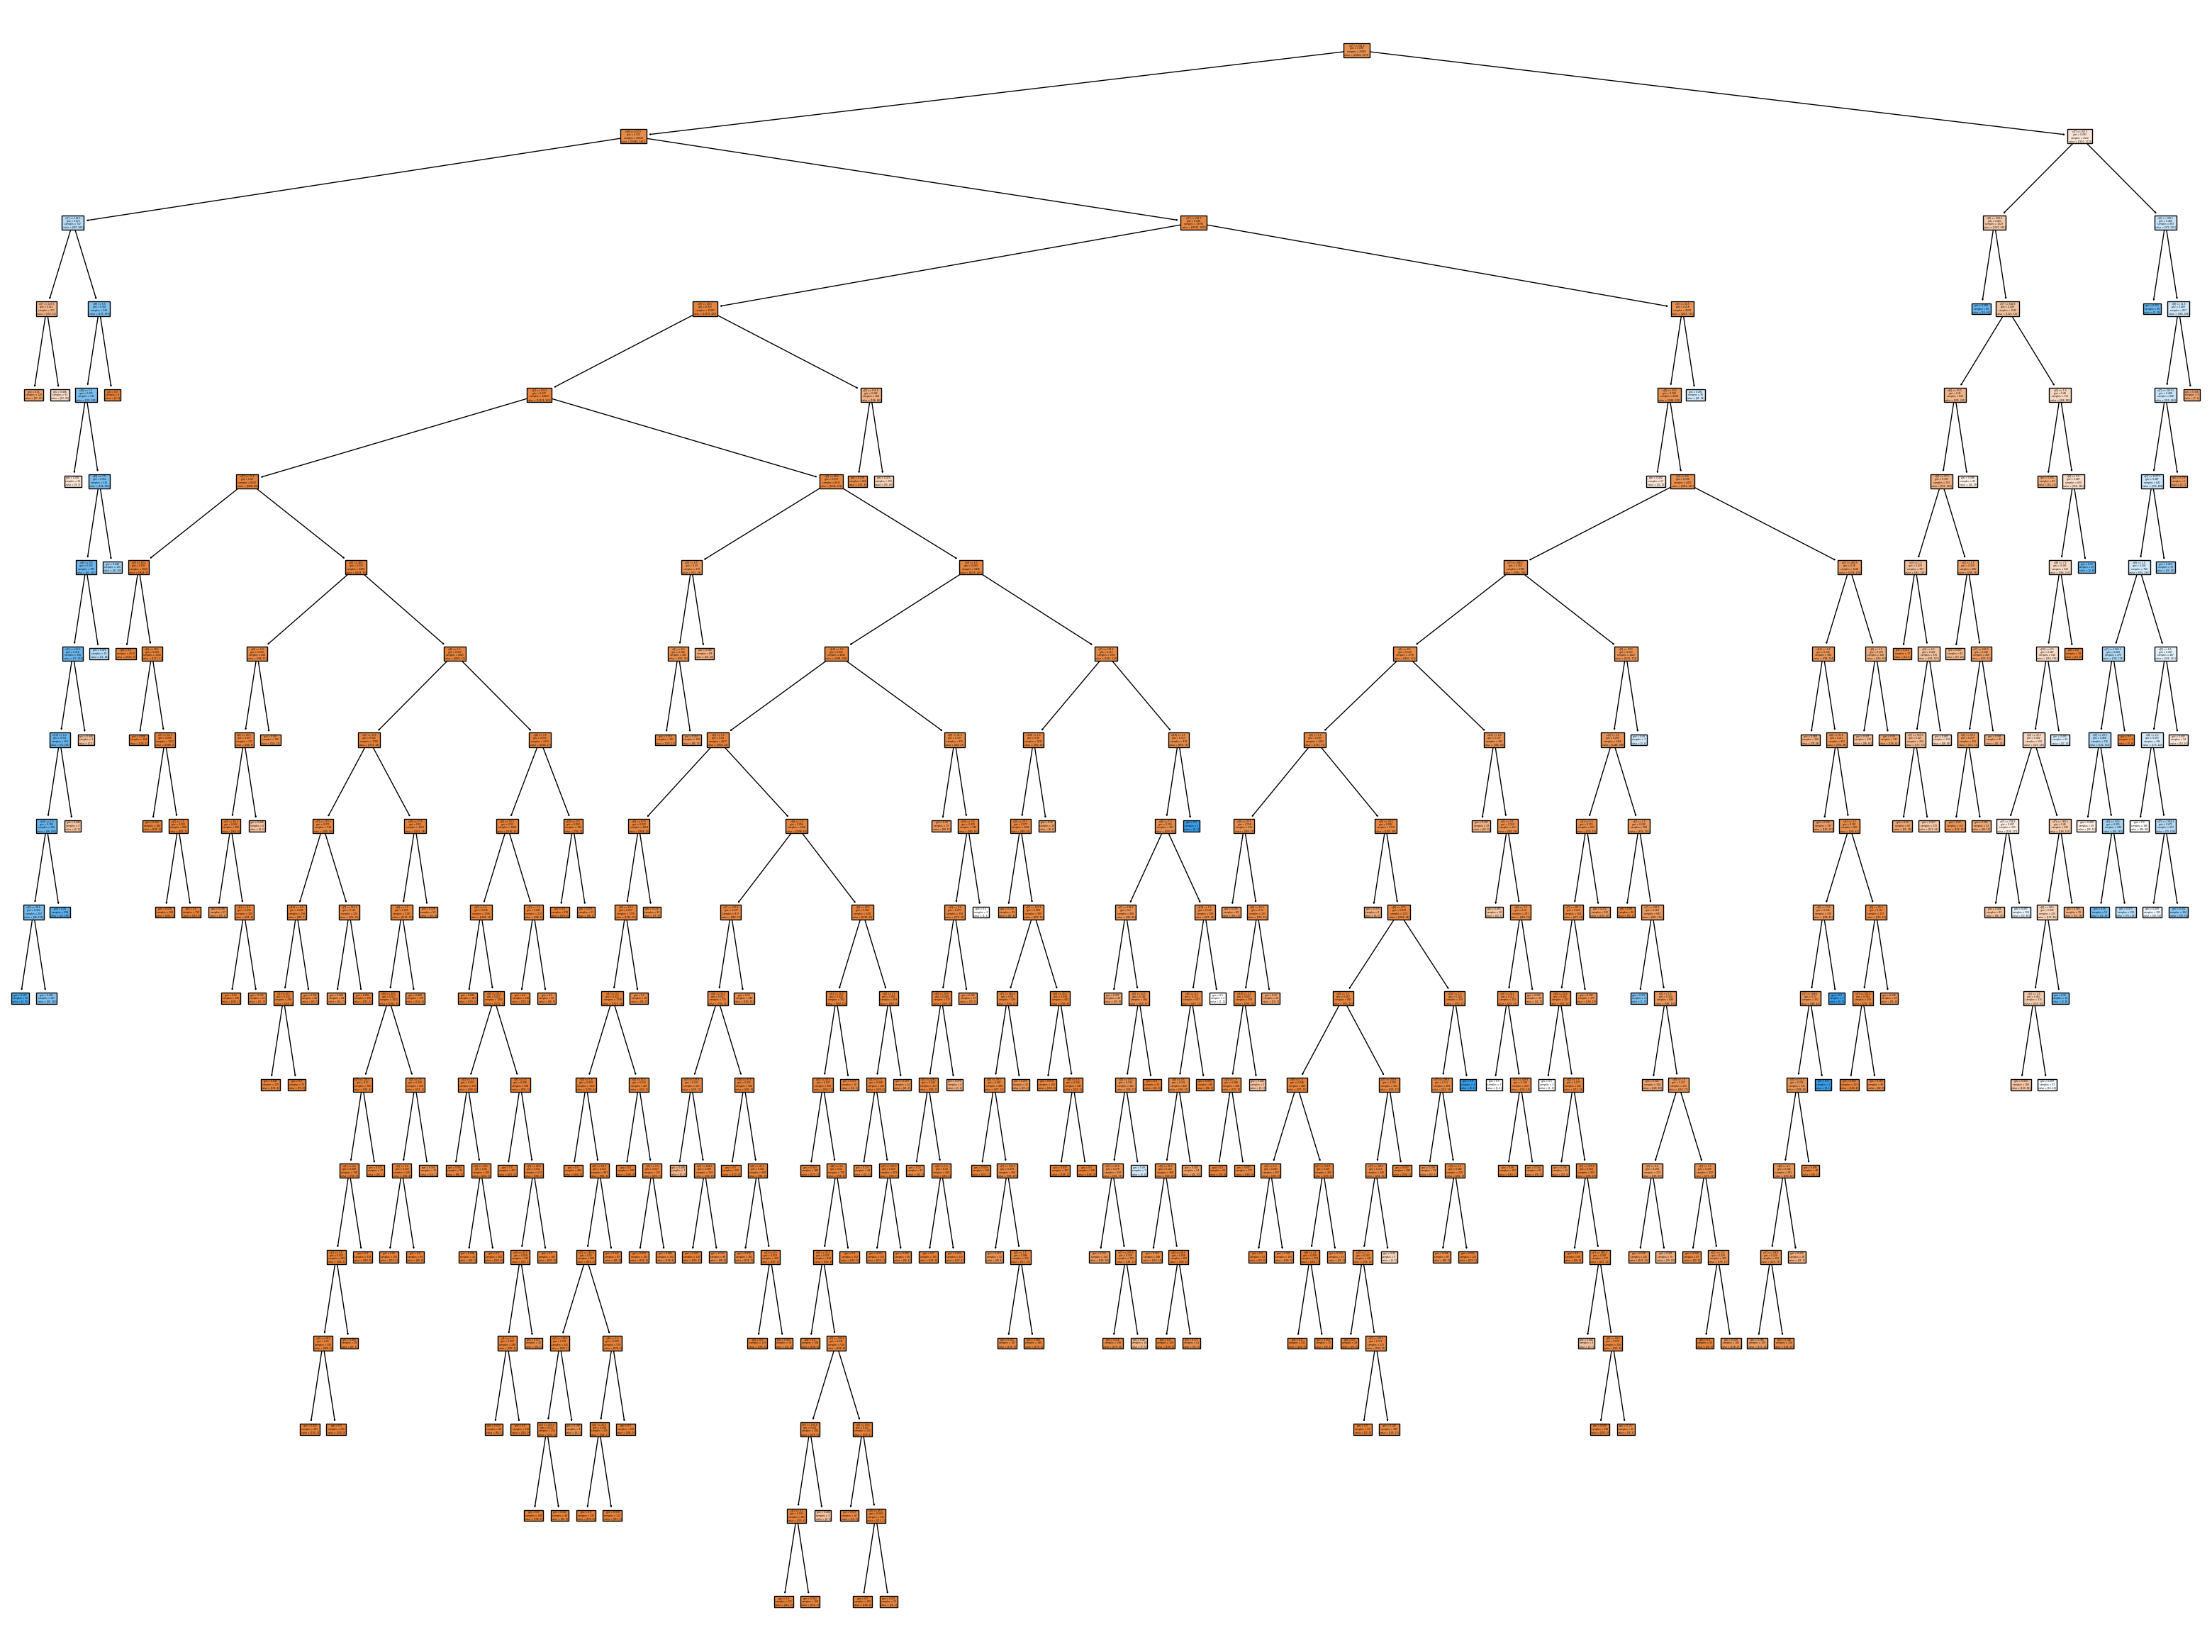

In [6]:
# 绘制决策树
fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(model, filled=True, ax=ax)  # filled=True可以给节点填充颜色，使图形更清晰
plt.savefig('银行数据决策树结构.png')

## 五、模型预测与评估

### 5.1 测试集上预测

In [7]:
## 在验证集上进行预测
# 模型预测
y_test_pred = model.predict(X_test)

$TP:$真正例（True Positive），即被分类器正确预测为正例的样本数  
$TN:$真反例（True Negative），即被分类器正确预测为反例的样本数  
$FP:$假正例（False Positive），即被分类器错误地预测为正例的样本数  
$FN:$假反例（False Negative），即被分类器错误地预测为反例的样本数  
### 5.2 准确率Accuracy
正确分类的样本数占总样本数的比例
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$

In [8]:
## 效果评价
# 准确率Accuracy--正确分类的样本数占总样本数的比例
acc = model.score(X_test, y_test)
print("Accuracy: ", acc)

Accuracy:  0.899645928174001


### 5.3 精确率precision
被分类器预测为正类的样本中，真正为正类的样本所占的比例
$$Precision = \frac{TP}{TP+FP}$$
### 5.4 召回率recall
真正为正类的样本中，被分类器预测为正类的样本所占的比例
$$Recall = \frac{TP}{TP+FN}$$
### 5.5 F1值f1score
综合考虑精确率和召回率，精确率和召回率的调和平均数
$$F1 = \frac{2 Precision Recall}{Precision+Recall}$$

In [9]:
# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8746
           1       0.61      0.35      0.45      1139

    accuracy                           0.90      9885
   macro avg       0.77      0.66      0.70      9885
weighted avg       0.88      0.90      0.89      9885



### 5.6 混淆矩阵

[[8495  251]
 [ 741  398]]


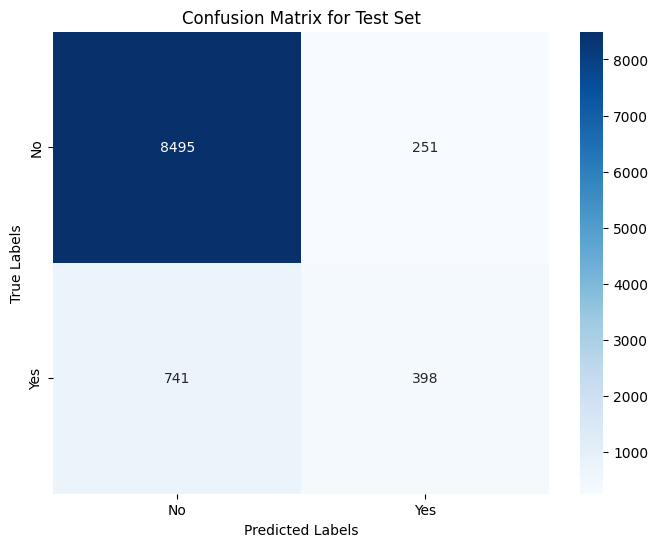

In [10]:
## 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Test Set")
plt.savefig(fname="银行数据测试集混淆矩阵.png")

### 5.7 学习率曲线
这一步大概4秒

learning_curve这一步耗时: 3.537655830383301 秒


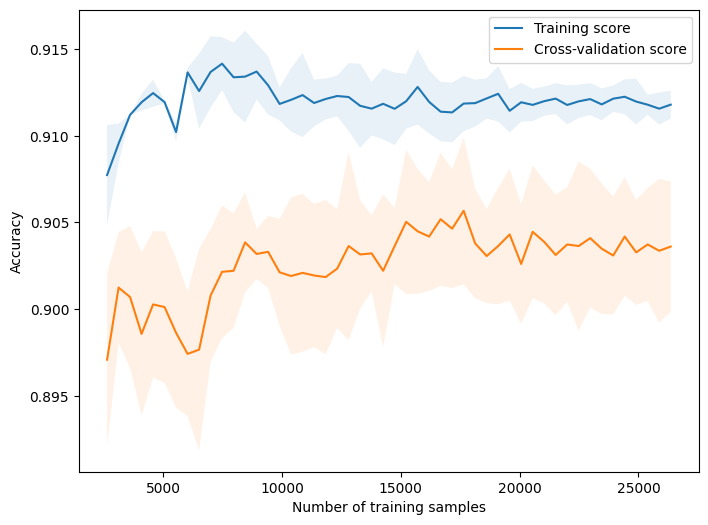

In [11]:
## 学习率曲线
'''
1、learning_curve函数可以用于生成学习曲线，帮助评估模型在不同训练集大小下的性能
2、cv：交叉验证的折数，这里指将原始数据集划分为5个互不重叠的子集，其中一个子集作为验证集，其余的4个子集作为训练集
3、n_jobs：指定使用的CPU数量，-1表示使用所有可用的CPU
4、train_sizes： # 指定训练集的大小，这里使用了10个不同的训练集大小，从10%到100%
5、scoring：指定评估指标，这里使用了准确率
'''
start_time_learning_curve = time.time()

train_sizes, train_scores, test_scores = learning_curve(
    model, 
    data_train[features],
    data_train[labels], 
    cv = 5, 
    n_jobs = -1,
    train_sizes = np.linspace(0.1, 1.0, 50),
    scoring = 'accuracy' 
    )

end_time_learning_curve = time.time()
print(f"learning_curve这一步耗时: {end_time_learning_curve - start_time_learning_curve} 秒")

# 计算平均值和标准差
train_mean = np.mean(train_scores, axis=1) # 训练集准确率均值
train_std = np.std(train_scores, axis=1) # 训练集准确率标准差
test_mean = np.mean(test_scores, axis=1) # 测试集准确率均值
test_std = np.std(test_scores, axis=1) # 测试集准确率标准差

# 绘制学习曲线图形
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score') # 绘制训练集准确率曲线
plt.plot(train_sizes, test_mean, label='Cross-validation score') # 绘制测试集准确率（交叉验证得分）曲线

# 绘制标准差区域
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.1) # 绘制训练集准确率标准差区域
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.1) # 绘制测试集准确率标准差区域

plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.savefig(fname="银行数据测试集学习率曲线.png")

可以看出，在训练集上相对较高，在测试集上随着样本数量的增加，准确率总体呈现增加的趋势

### 5.8 ROC曲线&AUC值

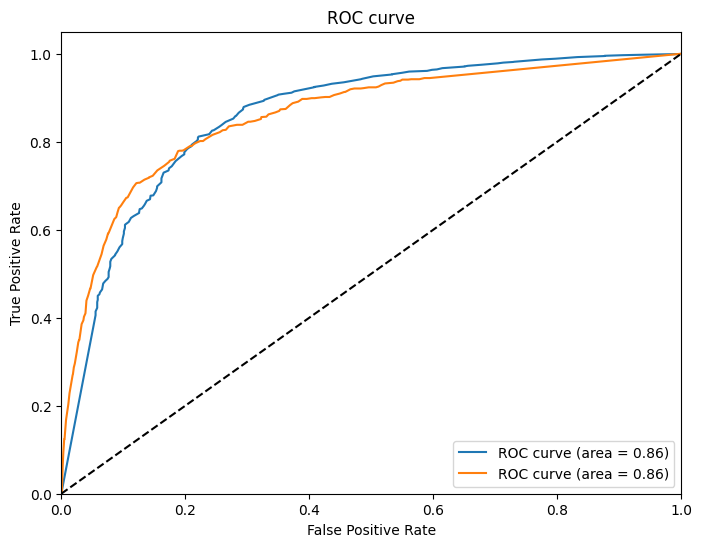

In [12]:
##  ROC曲线&AUC值
# 预测测试集中每个样本的概率分布
y_score = model.predict_proba(X_test)

# 计算每个类别的ROC曲线和AUC值
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制每个类别的ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0]) # 第一个类别的ROC曲线
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1]) # 第二个类别的ROC曲线
plt.plot([0, 1], [0, 1], 'k--') # 绘制对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right")
plt.savefig(fname="银行数据测试集ROC曲线&AUC值.png")

从结果上看，两个变量的ROC曲线表现的较好，AUC为0.86预测效果较好

## 六、决策树稳健性实验
将数据一分为二再二分为四，用四个模型输入以上模型，观察四个模型的预测情况来判断稳健性
### 6.1 数据集拆分

In [13]:
### 决策树稳健性实验
## 数据集拆分
data = data_train.sample(frac=1, replace=False)

# 第一次一分为二
half1, half2 = train_test_split(data, test_size=0.5)

# 第二次对half1再一分为二
data1, data2 = train_test_split(half1, test_size=0.5)

# 第二次对half2再一分为二
data3, data4 = train_test_split(half2, test_size=0.5)

print("data1的形状：", data1.shape)
print("data2的形状：", data2.shape)
print("data3的形状：", data3.shape)
print("data4的形状：", data4.shape)

print('前五行数据：')
print(data1.head())

data1的形状： (8237, 16)
data2的形状： (8238, 16)
data3的形状： (8237, 16)
data4的形状： (8238, 16)
前五行数据：
       age   job  marital  education  default  housing  loan  contact  month  \
9045    39   8.0      1.0        2.0      1.0      1.0   1.0        1      4   
26091   32   1.0      3.0        4.0      1.0      1.0   1.0        1      7   
15130   42   2.0      2.0        3.0      1.0      1.0   1.0        2      5   
25624   36   1.0      2.0        7.0      1.0      1.0   1.0        2      5   
15747   31  10.0      3.0        7.0      1.0      1.0   2.0        1      8   

       day_of_week  duration  campaign  pdays  previous  poutcome  labels  
9045             5       286         2    999         1         0       0  
26091            4        85         1    999         0         1       0  
15130            4       276         1    999         0         1       0  
25624            1       124         3    999         0         1       0  
15747            2        60         6    999   

### 6.2 划分数据

In [14]:
## 划分数据
features = ['age', 'job', 'marital', 'education',
            'default', 'housing', 'loan', 'duration',
            'campaign', 'pdays', 'previous', 'poutcome']
labels = 'labels'

# 划分训练集 70% 和测试集 30%
X1_train, X1_test, y1_train, y1_test = train_test_split(data1[features], data1[labels], train_size=0.7)
X2_train, X2_test, y2_train, y2_test = train_test_split(data2[features], data2[labels], train_size=0.7)
X3_train, X3_test, y3_train, y3_test = train_test_split(data3[features], data3[labels], train_size=0.7)
X4_train, X4_test, y4_train, y4_test = train_test_split(data4[features], data4[labels], train_size=0.7)

### 6.3 构建决策树模型

In [15]:
## 构建决策树模型
model1 = DecisionTreeClassifier(criterion='gini', min_samples_split=200).fit(X1_train, y1_train)
model2 = DecisionTreeClassifier(criterion='gini', min_samples_split=200).fit(X2_train, y2_train)
model3 = DecisionTreeClassifier(criterion='gini', min_samples_split=200).fit(X3_train, y3_train)
model4 = DecisionTreeClassifier(criterion='gini', min_samples_split=200).fit(X4_train, y4_train)

### 6.4 模型预测与评估

In [16]:
## 在验证集上进行预测
# 模型预测
y1_test_pred = model1.predict(X1_test)
y2_test_pred = model2.predict(X2_test)
y3_test_pred = model3.predict(X3_test)
y4_test_pred = model4.predict(X4_test)

## 效果评价
# 准确率Accuracy--正确分类的样本数占总样本数的比例
acc1 = model1.score(X1_test, y1_test)
print("数据集1对应模型的Accuracy: ", acc1)
acc2 = model2.score(X2_test, y2_test)
print("数据集2对应模型的Accuracy: ", acc2)
acc3 = model3.score(X3_test, y3_test)
print("数据集3对应模型的Accuracy: ", acc3)
acc4 = model4.score(X4_test, y4_test)
print("数据集4对应模型的Accuracy: ", acc4)

数据集1对应模型的Accuracy:  0.8911812297734628
数据集2对应模型的Accuracy:  0.901294498381877
数据集3对应模型的Accuracy:  0.9016990291262136
数据集4对应模型的Accuracy:  0.904126213592233


感觉稳健性还可以吧，也没那么差

## 七、模型对比
### 7.1 归一化与logistic回归建模

In [21]:
from sklearn.preprocessing import MinMaxScaler

### 模型对比
# 初始化归一化器
scaler = MinMaxScaler()

# 对训练集特征进行归一化
X_train_scaled = scaler.fit_transform(X_train)

# 对测试集特征进行归一化，注意这里是用训练集归一化器的参数来转换测试集
X_test_scaled = scaler.transform(X_test)

# 建立logistic回归模型
model_logit = LogisticRegression(max_iter=1000)
model_logit.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

### 7.2 模型预测与评估

In [22]:
# 模型预测
y_logit_pred = model_logit.predict(X_test_scaled)

## 效果评价
# 准确率Accuracy--正确分类的样本数占总样本数的比例
acc_logit = model_logit.score(X_test_scaled, y_test)
print("Logistic回归二分类的Accuracy: ", acc_logit)

# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
report_logit = classification_report(y_test, y_logit_pred)
print('Logistic回归二分类的结果：')
print(report_logit)

Logistic回归二分类的Accuracy:  0.9007587253414264
Logistic回归二分类的结果：
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      8746
           1       0.66      0.29      0.40      1139

    accuracy                           0.90      9885
   macro avg       0.79      0.64      0.67      9885
weighted avg       0.88      0.90      0.88      9885



但从准确率上看，两个模型效果基本一样，Logistic回归稍微高一点点